## 3 BayesianITC

Modeling ITC experiments using bellini. Huge thanks to David Minh's group at IIT for some of the equilibrium calculations code as well as the host-guest binding data!

Current unresolved issues:
- it takes a billion years for the model to compile, what's slowing it down? i suspect it's the for loop, so that's a TODO
- what exactly is DeltaH0? e.g. is it a heat of mixing or a baseline correction element

In [1]:
import bellini
from bellini.quantity import Quantity as Q
from bellini.groups import Species, Solution
from bellini.units import ureg
import jax
import jax.numpy as jnp
import numpy as np

In [2]:
# import data, courtesy of the Minh Group from IIT
import os
cwd = os.getcwd()
os.chdir("../../data")
DATA_DIR = os.getcwd() + "/"
os.chdir(cwd)

# These data are from host-guest binding, which can be used to test a simple binding model:
experiments = [
  {'type':'IsothermalTitrationCalorimetryIntegratedHeat',
   'file_name':DATA_DIR+'IsothermalTitrationCalorimetry/Mg-EDTA/Mg1EDTAp1a.DAT',
   'syringe_concentrations':{'L':1.0E-3},
   'cell_concentrations':{'R':0.1E-3},
   'cell_volume':0.001434},
  {'type':'IsothermalTitrationCalorimetryIntegratedHeat',
   'file_name':DATA_DIR+'IsothermalTitrationCalorimetry/Mg-EDTA/Mgp5EDTAp05a.DAT',
   'syringe_concentrations':{'L':0.5E-3},
   'cell_concentrations':{'R':0.05E-3},
   'cell_volume':0.001434}
   ]

def load_IsothermalTitrationCalorimetryIntegratedHeat(file_name):
    """
    :param file_name: str, name of microcal heat file
    :return: (DeviceArray, DeviceArray), (heats in calories, volumes in L)
    """
    heats = []
    volumes = []
    with open(file_name) as handle:
      handle.readline() # Reads the header
      for line in handle:
        cols = line.split()
        if cols[0] != '--':
          heats.append(float(cols[0])*1E-6) # convert from μcal to cal
          volumes.append(float(cols[1])*1E-6) # convert from μL to L
    return (np.array(heats), np.array(volumes))

for experiment in experiments:
  print(f"Loading {experiment['file_name']}")
  if experiment['type'] == 'IsothermalTitrationCalorimetryIntegratedHeat':
    (heats, volumes) = \
      load_IsothermalTitrationCalorimetryIntegratedHeat(experiment['file_name'])
    experiment['injection_heats'] = heats
    experiment['injection_volumes'] = volumes

# just taking a sneak peak of the data
experiments

Loading /home/alex/Documents/chodera_lab/bellini/data/IsothermalTitrationCalorimetry/Mg-EDTA/Mg1EDTAp1a.DAT
Loading /home/alex/Documents/chodera_lab/bellini/data/IsothermalTitrationCalorimetry/Mg-EDTA/Mgp5EDTAp05a.DAT


[{'type': 'IsothermalTitrationCalorimetryIntegratedHeat',
  'file_name': '/home/alex/Documents/chodera_lab/bellini/data/IsothermalTitrationCalorimetry/Mg-EDTA/Mg1EDTAp1a.DAT',
  'syringe_concentrations': {'L': 0.001},
  'cell_concentrations': {'R': 0.0001},
  'cell_volume': 0.001434,
  'injection_heats': array([-2.772430e-05, -2.899697e-05, -2.892312e-05, -2.884158e-05,
         -2.882591e-05, -2.888749e-05, -2.800774e-05, -2.733818e-05,
         -2.065130e-05, -9.139800e-06, -3.761440e-06, -1.943890e-06,
         -1.627770e-06, -1.045790e-06, -1.054640e-06, -1.034880e-06,
         -1.130120e-06, -1.036560e-06, -7.545200e-07, -9.018900e-07,
         -9.904100e-07, -8.517100e-07, -9.327900e-07]),
  'injection_volumes': array([1.2e-05, 1.2e-05, 1.2e-05, 1.2e-05, 1.2e-05, 1.2e-05, 1.2e-05,
         1.2e-05, 1.2e-05, 1.2e-05, 1.2e-05, 1.2e-05, 1.2e-05, 1.2e-05,
         1.2e-05, 1.2e-05, 1.2e-05, 1.2e-05, 1.2e-05, 1.2e-05, 1.2e-05,
         1.2e-05, 1.2e-05])},
 {'type': 'IsothermalTitrati

To start constructing our ITC protocol, we need to define a few things:
- a Law which computes both binding equilibrium and heat released / absorbed
- a procedure which repeatedly performs injections and analyzes the system pre- and post-injection

We'll start off by constructing the Law. We'll be borrowing some code form the Minh Group from IIT

In [3]:
# define some experimental objects
ligand = Species("L")
receptor = Species("R")
bound_complex = Species("RL")
buffer = Species("buffer")

In [4]:
# modified from `global_analysis_numpyro_Simple.ipynb`, courtesy of Minh Group from IIT

class ChemicalReactions(object):
   """ Computes concentrations of species for a system of chemical equations

   In ceq, equilibrium concentrations are determined by solving the system of 
   chemical equations and conservation equations using an optimization algorithm.
   It is adapted from https://github.com/choderalab/assaytools/blob/818115021fa2cbe11b502908f45fb7d56602b2d4/AssayTools/bindingmodels.py#L243
   In ct, time series are determined from  integrating the rate equations using 
   a ordinary differential equation solver.
   In xi, the extent of each chemical reaction is obtained via a linear least 
   squares regression.
   """
   def __init__(self, chemical_equations, conservation_equations):
      """
      Parameters
      ----------
      chemical_equations : list of dict
          List of chemical_equations, encoded as a dict of stoichiometry of each species
          Example: RL ⇋ R + L is {'RL': -1, 'R' : +1, 'L' : +1}
      conservation_equations : list of dict
          List of mass conservation laws, encoded as a dict of amounts in each species
          Example: [RL] + [R] is {'RL' : +1, 'R' : +1}
      """
      nchemical_equations = len(chemical_equations)
      nconservation_equations = len(conservation_equations)
      nequations = nchemical_equations + nconservation_equations

      # Determine names of all species
      all_species = []
      for chemical_equation in chemical_equations:
        for species in chemical_equation.keys():
          if species not in all_species:
            all_species.append(species)
      all_species = sorted(all_species, key = lambda x: x.name) # order is now fixed
      nspecies = len(all_species)

      index_of_species = dict([(species,J) for (J,species) in enumerate(all_species)])

      # The stoichiometry matrix helps determine the extent of the reaction
      stoichiometry_matrix = np.zeros((nspecies, nchemical_equations))
      for R in range(nchemical_equations):
        for J in range(nspecies):
          if all_species[J] in chemical_equations[R].keys():
            stoichiometry_matrix[J][R] = chemical_equations[R][all_species[J]]

      # The conservation matrix helps obtain the total concentration
      conservation_matrix = np.zeros((nspecies, nconservation_equations))
      for (R, conservation_equation) in enumerate(conservation_equations):
        for (species, nu) in conservation_equation.items():
          conservation_matrix[index_of_species[species]][R] += nu

      self.all_species = all_species
      self.index_of_species = index_of_species
      self.nspecies = nspecies
      self.chemical_equations = chemical_equations
      self.nchemical_equations = nchemical_equations
      self.conservation_equations = conservation_equations
      self.nconservation_equations = nconservation_equations
      self.stoichiometry_matrix = jnp.array(stoichiometry_matrix)
      self.conservation_matrix = jnp.array(conservation_matrix)

   def logceq(self, logKeq, logctot, iters=5):
      """ Equilibrium concentrations

      Parameters
      ----------
      logKeq : jnp.array
          Log equilibrium constants.
      logctot : jnp.array
          Log total concentrations (log M).
      iters : int
          Number of Gauss-Newton iterations
      Returns
      -------
      logc : numpy.array
          logc[J] is the log concentration of species J
      Examples
      --------
      Simple 1:1 association
      >>> chemical_equations = [ {'RL': -1, 'R' : +1, 'L' : +1} ]
      >>> conservation_equations = [ {'RL' : +1, 'R' : +1}, {'RL' : +1, 'L' : +1} ]
      >>> simple_binding = ChemicalReactions(chemical_equations, conservation_equations)
      >>> log_complex_concentrations = simple_binding.logceq([np.log(1E-6)], [np.log(5E-9), np.log(1E-5)])      
      Competitive 1:1 association
      >>> chemical_equations = [ {'RLa': 1, 'R' : -1, 'La' : -1 }, {'RLb': 1, 'R' : -1, 'Lb' : -1 } ]
      >>> conservation_equations = [ {'RLa' : +1, 'RLb' : +1, 'R' : +1}, {'RLa' : +1, 'La' : +1}, {'RLb' : +1, 'Lb' : +1} ]
      >>> competitive_binding = ChemicalReactions(chemical_equations, conservation_equations)
      >>> logc = competitive_binding.logceq([-np.log(1E-9), -np.log(10E-9)], [np.log(1E-6), np.log(5E-7), np.log(5E-7)])
      """
      # Initial guess
      maxlogc = jnp.max(logctot)
      logci = jnp.array(np.ones((self.nspecies))*maxlogc)
      
      # Gauss-Newton update
      def f(logc, xs):
        min_logc = jnp.min(logc)
        logsum = jnp.log(jnp.exp(logc - min_logc) @ self.conservation_matrix) \
          + min_logc
        eps = jnp.concatenate((\
          logc @ self.stoichiometry_matrix - logKeq, \
          logsum - logctot))
        ssd_i = jnp.sum(jnp.square(eps))
        J = jnp.vstack([self.stoichiometry_matrix.T, 
          self.conservation_matrix.T * jnp.exp(\
            jnp.tile(logc, (self.nconservation_equations,1)) - \
            jnp.tile(logsum, (self.nspecies,1)).T)])
        delta = jnp.linalg.inv(J.T @ J) @ J.T @ eps     
        logc = logc - delta
        logc = jnp.min(jnp.vstack([logc, logci]),0)
        return (logc, ssd_i)

      # Run Gauss-Newton until acceptable tolerance
      # logc = jax.lax.while_loop(cond_fun, body_fun, logci)
      (logc, ssd) = jax.lax.scan(f, logci, None, length=iters)
      # assert(ssd[-1]<tol)
      return logc

    
class SimpleBinding(ChemicalReactions):
  def __init__(self):
    chemical_equations = [ {bound_complex: 1, receptor : -1, ligand : -1} ]
    conservation_equations = [ {bound_complex : +1, receptor : +1}, {bound_complex : +1, ligand : +1} ]
    super().__init__(chemical_equations, conservation_equations)

  def logceq(self, logKeq, logctot):
    """ Equilibrium concentrations from the simple binding model

    Parameters
    ----------
    logKeq : jnp.array
        Log equilibrium constants.
    logctot : jnp.array
        Log total concentrations (log M).

    Returns
    -------
    logc : numpy.array
        logc[J] is the log concentration of species J

    """
    '''
    logL = logctot[0]
    logR = logctot[1]
    logRLK = jnp.logaddexp(jnp.logaddexp(logL, logR) + logKeq[0])
    RLK = jnp.exp(logRLK)
    '''
    ctot = jnp.exp(logctot)
    b = -(ctot[0] + ctot[1] + jnp.exp(-logKeq[0]))
    c = ctot[0]*ctot[1]
    sqrt_arg = jnp.square(b) - 4*c
    sqrt_arg = jnp.where(sqrt_arg>0, sqrt_arg, 0)
    xi = (-b - jnp.sqrt(sqrt_arg))/2.
    # self.index_of_species = {'L': 0, 'R': 1, 'RL': 2}
    pre_log = jnp.array([ctot[1]-xi, ctot[0]-xi, xi])
    pre_log = jnp.where(pre_log > 0, pre_log, 0)
    return jnp.log(pre_log)

The above code essentially computes the binding equilibrium given an equilibrium constant. Let's place a Uniform prior over this (logKeq), as well as a heat of binding (DeltaH) which we'll need to compute the binding heat values.

In [5]:
from bellini.distributions import Uniform, gen_lognorm, Normal, TruncatedNormal

# construct binding model
binding_model = SimpleBinding()

# quantities we want to infer
logKeq = Uniform(
    low=Q(
        np.array([0.0]*binding_model.nchemical_equations),
        ureg.dimensionless
    ), 
    high=Q(
        np.array([33.5]*binding_model.nchemical_equations),
        ureg.dimensionless
    ),
    name="logKeq"
)

DeltaH = Uniform(
    low=Q(
        jnp.array([-100E3]*binding_model.nchemical_equations), 
        ureg.cal / ureg.mole
    ), 
    high=Q(
        jnp.array([0E3]*binding_model.nchemical_equations),
        ureg.cal / ureg.mole
    ),
    name="DeltaH [cal/mol]"
)


We'll use the model `SimpleBinding` and these parameters to construct a `Law` that computes both binding equilibrium and heat of reaction. First, we build `calc_heats`, which does the actual hard-core computations. Then, we wrap it into an `itc_law`, which is generated based on the per-experiment parameter `DeltaH0`:

In [6]:
from bellini.containers import Container
from bellini.laws import Law
from bellini.reference import Reference as Ref

# Refs that we'll need to construct the Law
conc_ref = Ref("concentrations") # pointing to the concentration of the solution
q_rel_ref = Ref("q_rel") # pointing to the 

# defined for a simple two-component binding system
def calc_heats(logKeq, DeltaH, DeltaH0, init_vol, final_vol, conc_current_dict, conc_previous_dict):   
    """
    Parameters
    ----------
    
    logKeq: Quantity (ureg.dimensionless)
        log of equilibrium constant
    
    DeltaH: Quantity (dimensionality same as ureg.cal / ureg.mole)
        Heat of Reaction 
        
    DeltaH0: Quantity (dimensionality same as ureg.cal)
        Heat of mixing (?)
        
    init_vol: Quantity (dimensionality same as ureg.milliliter)
        Volume of solution pre-injection
        
    final_vol: Quantity (dimensionality same as ureg.milliliter)
        Volume of solution post-injection
    
    conc_current: dict of Species -> Quantity (dimensionality same as ureg.molar)
        Concentrations of species assuming 0 reaction progress post-injection
        
    conc_previous: dict of Species -> Quantity (dimensionality same as ureg.molar)
        Concentrations of species at equilibrium pre-injection
        
    Returns
    -------
    
    dict of Reference -> Quantity (various dimensionlities)
    
    Returns the heat released by injection, as well as the equilibrium concentrations of
    species
    """
    
    def species_dict_to_array(species_dict):
        """ Convert a species dict into a jnp.ndarray with a defined ordering """
        # create jnp.ndarray of previous equilibrum concentrations
        cJn = jnp.zeros((binding_model.nspecies))
        for (J, species) in enumerate(binding_model.all_species):
            if species.name in species_dict.keys():
                cJn = cJn.at[J].set(species_dict[species.name].to(ureg.molar).magnitude)
        return cJn
    
    def equilib_calc(species_dict):
        """ Compute equilibrium calculations given a species_dict, then place results
        in a jnp.ndarray with a defined ordering """
        cJn = species_dict_to_array(species_dict)
        ctot = cJn @ binding_model.conservation_matrix
        # compute equilibrium again (redundant calculation but just to be safe)
        ctot = jnp.where(ctot > 0, ctot, 0) # ensure numerical stability
        logc = binding_model.logceq(logKeq, jnp.log(ctot))
        conc = jnp.exp(logc)
        return conc
        
    # convert Quantities to expected units, then strip units
    logKeq = logKeq.magnitude
    DeltaH = DeltaH.to_units(ureg.cal / ureg.mole).magnitude
    DeltaH0 = DeltaH0.to_units(ureg.cal).magnitude
    final_vol = final_vol.to_units(ureg.liter).magnitude
    init_vol = init_vol.to_units(ureg.liter).magnitude
    
    # compute pre-injection equilibrium
    # this should be unnecessary since equilibrium is already computed 
    # when constructing the pre-inject solution but i left it in just to be safe
    conc_prev_arr = equilib_calc(conc_previous_dict)
    # compute post-injection equilibrium
    conc_current_arr = equilib_calc(conc_current_dict)
    
    # compute heat released
    bound_complex_idx = binding_model.index_of_species[bound_complex]
    q_rel = jnp.sum(DeltaH * 
        (final_vol * conc_current_arr[bound_complex_idx] 
         - init_vol * conc_prev_arr[bound_complex_idx])
    ) + DeltaH0
    
    return {
        q_rel_ref: Q(q_rel, ureg.cal),
        conc_ref[ligand]: Q(conc_current_arr[0], ureg.molar),
        conc_ref[receptor]: Q(conc_current_arr[1], ureg.molar),
        conc_ref[bound_complex]: Q(conc_current_arr[2], ureg.molar)
    }

Now we construct an `itc_law`. The structure is very similar to that shown in the "2 Binding Models" example, except the `input_mapping` is a little different. Notably, it's now in a dict-of-dict structure. The outer layer of the dict is indexed by ints, which represents the number of timesteps previous to the current solution you're pulling arguments from. Specifically, the input mapping from the dictionary indexed at 0 will be pulled from the post-injection solution (0 timesteps back), while the input mapping from the dictionary indexed at 1 will be pulled from the pre-injection solution (1 timestep back). The structure of each of these inner dictionaries is the same as that "2 Binding Models"

In [7]:
def create_eq_group(law_output, group, law):
    mixture = []
    for ref, output in law_output.items():
        if ref.is_base():
            continue
        idx1 = ref.slices[0]
        if isinstance(idx1, Species):
            moles = output * group.volume * idx1
            mixture.append(moles)
    
    base_mix = mixture[0]
    for sub in mixture[1:]:
        base_mix = base_mix + sub
    
    lawed_sol = Solution(
        mixture = base_mix,
        solvent = group.solvent
    )  
    
    for ref, output in law_output.items():
        if not ref.is_base():
            continue
        name = ref.name
        setattr(lawed_sol, name, output)
    
    return lawed_sol

# we use a function to generate this Law since DeltaH0 varies per experiment
def gen_itc_law(DeltaH0):
    itc_law = Law(
        law_fn=calc_heats,
        input_mapping={
            0 : {
                "conc_current_dict" : {
                    ligand.name: conc_ref[ligand],
                    receptor.name: conc_ref[receptor],
                    bound_complex.name: conc_ref[bound_complex]
                },
                "final_vol": "volume"
            },
            1 : {
                "conc_previous_dict" : {
                    ligand.name: conc_ref[ligand],
                    receptor.name: conc_ref[receptor],
                    bound_complex.name: conc_ref[bound_complex]
                },
                "init_vol": "volume"
            }
        },
        params={
            "DeltaH": DeltaH,
            "DeltaH0": DeltaH0,
            "logKeq": logKeq
        },
        name="itc_law:" + repr(DeltaH0),
        group_create_fn=create_eq_group
    )
    return itc_law

With our `Law` in hand, let's create a `Procedure` ITC routine. This involves successive injections, law computations, and heat measurements over all injection volumes. An important thing to note is that we now feed a `timesteps` argument to `apply_law`, which tells `Procedure` how many timesteps in the past to feed to `Law`.

In [8]:
def perform_ITC(procedure, 
                container,
                inject_source,
                inject_dev,
                measure_dev,
                inject_vols,
                itc_law):
    p = procedure
    heats = []
    for vol in inject_vols:
        p.perform(inject_dev, source_ref = inject_source, sink_ref = container, volume=vol)
        p.apply_law(itc_law, container_name = container, timesteps=2)
        H_measured = p.measure(measure_dev, container_ref = container, value=q_rel_ref)
        heats.append(H_measured)
    return p, heats

We've finally finished constructing our routine! Phew. Time to create the actual procedure and run it through our ITC routine.

In [9]:
# experimental devices
from bellini.devices import LiquidTransfer, Measurer
syringe = LiquidTransfer("syringe", var=Q(0.1, ureg.microliter), noise_model = None)
heat_measurer = Measurer("heat_measurer", var=Q(1, ureg.microcal))

# create procedure
from bellini.procedure import Procedure
procedure = Procedure(
    devices={
        "syringe": syringe,
        "heat_measurer": heat_measurer
    }
)    

# we'll store our experimental outputs in this list
results = []

# we repeat the same routine over all experiments of the same system
for n, exp in enumerate(experiments):
    # compute cell quantities
    cell_volume = Q(exp['cell_volume'], ureg.liter)
    cell_conc = Q(exp['cell_concentrations']['R'], ureg.mole/ureg.liter)
    # add uncertainty
    cell_conc = TruncatedNormal(Q(0, ureg.molar), cell_conc, 0.1 * cell_conc, name=f"cell_conc:{n} [molar]")
    
    # create cell
    initial_cell_solution = Solution(
        cell_conc * cell_volume * receptor,
        cell_volume * buffer
    )
    cell = Container(initial_cell_solution, name="initial cell")
    
    # compute injection quantities
    ligand_conc = Q(exp['syringe_concentrations']['L'], ureg.mole/ureg.liter)
    inject_vols = Q(exp['injection_volumes'], ureg.liter)
    # add uncertainty
    ligand_conc = TruncatedNormal(Q(0, ureg.molar), ligand_conc, ligand_conc * 0.01, name=f"ligand_conc:{n} [molar]")
    
    # create ligand source
    ligand_source_vol = Q(1, ureg.milliliter)
    ligand_source_sol = Solution(
        ligand_conc * ligand_source_vol * ligand,
        ligand_source_vol * buffer
    )
    ligand_source = Container(ligand_source_sol, name="initial ligand")
    
    # we now add our cell and our ligand source into the procedure
    procedure.register("cell" + str(n), cell)
    procedure.register("ligand_source" + str(n), ligand_source)
    
    # DeltaH0 is specific to the experiment
    q_min = Q(np.min(exp['injection_heats']), ureg.cal)
    q_max = Q(np.max(exp['injection_heats']), ureg.cal)
    Deltaq = q_max - q_min
    name = f'DeltaH0:{n:04d} [cal]'
    DeltaH0 = Uniform(low=q_min-Deltaq, high=q_max+Deltaq, name=name)
    
    # generate the itc_law specific to this experiment
    itc_law = gen_itc_law(DeltaH0)
    
    # perform ITC routine
    procedure, heats = perform_ITC(
        procedure=procedure,
        container=f"cell{n}",
        inject_source=f"ligand_source{n}",
        inject_dev="syringe",
        measure_dev="heat_measurer",
        inject_vols=inject_vols,
        itc_law=itc_law
    )
    
    # pair together the experiment results as well as the predicted results 
    exp_results = Q(exp['injection_heats'], ureg.cal)
    results.append([heats, exp_results])
    

In [10]:
# you could generate a procedure graph, but it's sorta a mess because of how many operations we do
# you can uncomment this code block if you want to see it

"""
import matplotlib.pyplot as plt
import networkx as nx

subset_color = [
    "gold",
    "violet",
    "limegreen",
    "darkorange",
    "gold",
    "violet",
    "limegreen",
    "darkorange",
] * 20

G = procedure.g
color = [subset_color[data['layer']] for v, data in G.nodes(data=True)]
plt.figure(figsize=(256, 32))
pos = nx.multipartite_layout(G, subset_key="layer", scale=2)
nx.draw(G, pos, node_color=color, with_labels=True)
plt.axis("equal")
plt.show()
"""


'\nimport matplotlib.pyplot as plt\nimport networkx as nx\n\nsubset_color = [\n    "gold",\n    "violet",\n    "limegreen",\n    "darkorange",\n    "gold",\n    "violet",\n    "limegreen",\n    "darkorange",\n] * 20\n\nG = procedure.g\ncolor = [subset_color[data[\'layer\']] for v, data in G.nodes(data=True)]\nplt.figure(figsize=(256, 32))\npos = nx.multipartite_layout(G, subset_key="layer", scale=2)\nnx.draw(G, pos, node_color=color, with_labels=True)\nplt.axis("equal")\nplt.show()\n'

In order to compile this procedure into a model, we need to collect the graphs from all the measurements we created.

In [11]:
# this step takes a while because generating these graphs is pretty expensive
graphs = []
obs_data = {}
for measurements, heats in results:
    for i, obs in enumerate(measurements):
        q_tot = obs[q_rel_ref]
        obs_data[q_tot] = heats[i]
        graphs.append(q_tot.g)

In [12]:
# you could generate a nx computation graph, but again it's sorta a mess because of how many operations we do
# you can uncomment this code block if you want to see it
"""
# This example needs Graphviz and either PyGraphviz or pydot
# from networkx.drawing.nx_pydot import graphviz_layout
from networkx.drawing.nx_agraph import graphviz_layout

G = nx.compose_all(graphs)

pos = graphviz_layout(G, prog='dot', args='-Granksep=6') #pos = nx.drawing.layout.spiral_layout(G)
plt.figure(figsize=(32, 32))
nx.draw(G, pos, node_size=40, alpha=0.5, node_color="blue", with_labels=True, arrowsize=60)
#nx.draw_networkx_labels(G,pos,labels, font_color='r', font_size='30')
plt.axis("equal")
plt.show()
"""


'\n# This example needs Graphviz and either PyGraphviz or pydot\n# from networkx.drawing.nx_pydot import graphviz_layout\nfrom networkx.drawing.nx_agraph import graphviz_layout\n\nG = nx.compose_all(graphs)\n\npos = graphviz_layout(G, prog=\'dot\', args=\'-Granksep=6\') #pos = nx.drawing.layout.spiral_layout(G)\nplt.figure(figsize=(32, 32))\nnx.draw(G, pos, node_size=40, alpha=0.5, node_color="blue", with_labels=True, arrowsize=60)\n#nx.draw_networkx_labels(G,pos,labels, font_color=\'r\', font_size=\'30\')\nplt.axis("equal")\nplt.show()\n'

It's time to perform inference! Let's use this (same) helper class to do some inference:

In [13]:
import numpy as np
import numpyro
import numpyro.distributions as dist
import arviz as az
import jax
import jax.numpy as jnp
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive
import matplotlib.pyplot as plt
import networkx as nx

niter = 500000  # number of iterations
nburn = 50000  # number of burn-in iterations to discard
nthin = 500  # thinning interval

class MCMCModel:
    def __init__(
        self,
        model,
        kernel_args={'step_size':1},
        mcmc_args={"num_warmup": nburn, "num_samples": niter, "thinning": nthin},
    ):
        self.model = model
        self.mcmc = None
        self.kernel_args = kernel_args
        self.mcmc_args = mcmc_args
        self.params = None
        rng_key = random.PRNGKey(0)  # TODO: make option to choose random seed
        self.rng_key_infer, self.rng_key_predict = random.split(rng_key)

    def run_mcmc(self, *args, **kwargs):
        nuts_kernel = NUTS(self.model, **self.kernel_args)
        self.mcmc = MCMC(nuts_kernel, **self.mcmc_args)
        self.mcmc.run(self.rng_key_infer, *args, **kwargs)
        self.sample_params()

    def sample_params(self):
        self.params = self.mcmc.get_samples()

    def predict(self, *args, **kwargs):
        predictor = Predictive(self.model, self.params)
        return predictor(self.rng_key_predict, *args, **kwargs)

    def plot_results(self, exclude_deterministic=False):
        self.mcmc.print_summary(exclude_deterministic=exclude_deterministic)
        data = az.from_numpyro(self.mcmc)
        az.plot_trace(data)

In [14]:
# this step takes a long time (on the order of 10s of minutes), likely because it takes a while for JAX to unroll our for loops
# which is definitely something that needs to be worked on. but inference itself is pretty fast once everything is compiled

from bellini.api._numpyro import graphs_to_numpyro_model

model = graphs_to_numpyro_model(graphs)
mcmc_wrapper = MCMCModel(model, mcmc_args={"num_warmup": 20000, "num_samples": 20000, "thinning": 1})
mcmc_wrapper.run_mcmc(obs=obs_data)

/home/alex/anaconda3/envs/chodera/lib/python3.9/site-packages/bellini-0+untagged.132.g47ab668.dirty-py3.9.egg/bellini/distributions.py:189: UserWarning: We only allow comparisons so that numpyro can sort keys during inference. You otherwise really shouldn't beusing __lt__
  warnings.warn(("We only allow comparisons so that numpyro can sort "
/home/alex/anaconda3/envs/chodera/lib/python3.9/site-packages/bellini-0+untagged.132.g47ab668.dirty-py3.9.egg/bellini/distributions.py:189: UserWarning: We only allow comparisons so that numpyro can sort keys during inference. You otherwise really shouldn't beusing __lt__
  warnings.warn(("We only allow comparisons so that numpyro can sort "
sample: 100%|██████████| 40000/40000 [05:35<00:00, 119.40it/s, 15 steps of size 3.88e-01. acc. prob=0.91] 



                             mean       std    median      5.0%     95.0%     n_eff     r_hat
    DeltaH [cal/mol][0]  -2327.66     45.58  -2327.08  -2400.62  -2251.18  10530.38      1.00
     DeltaH0:0000 [cal]     -0.00      0.00     -0.00     -0.00     -0.00  13554.61      1.00
     DeltaH0:0001 [cal]     -0.00      0.00     -0.00     -0.00     -0.00  12707.98      1.00
    cell_conc:0 [molar]      0.00      0.00      0.00      0.00      0.00  12173.32      1.00
    cell_conc:1 [molar]      0.00      0.00      0.00      0.00      0.00  13996.93      1.00
  ligand_conc:0 [molar]      0.00      0.00      0.00      0.00      0.00  11678.18      1.00
  ligand_conc:1 [molar]      0.00      0.00      0.00      0.00      0.00  15204.60      1.00
              logKeq[0]     15.36      0.24     15.36     14.98     15.76  15870.12      1.00

Number of divergences: 0


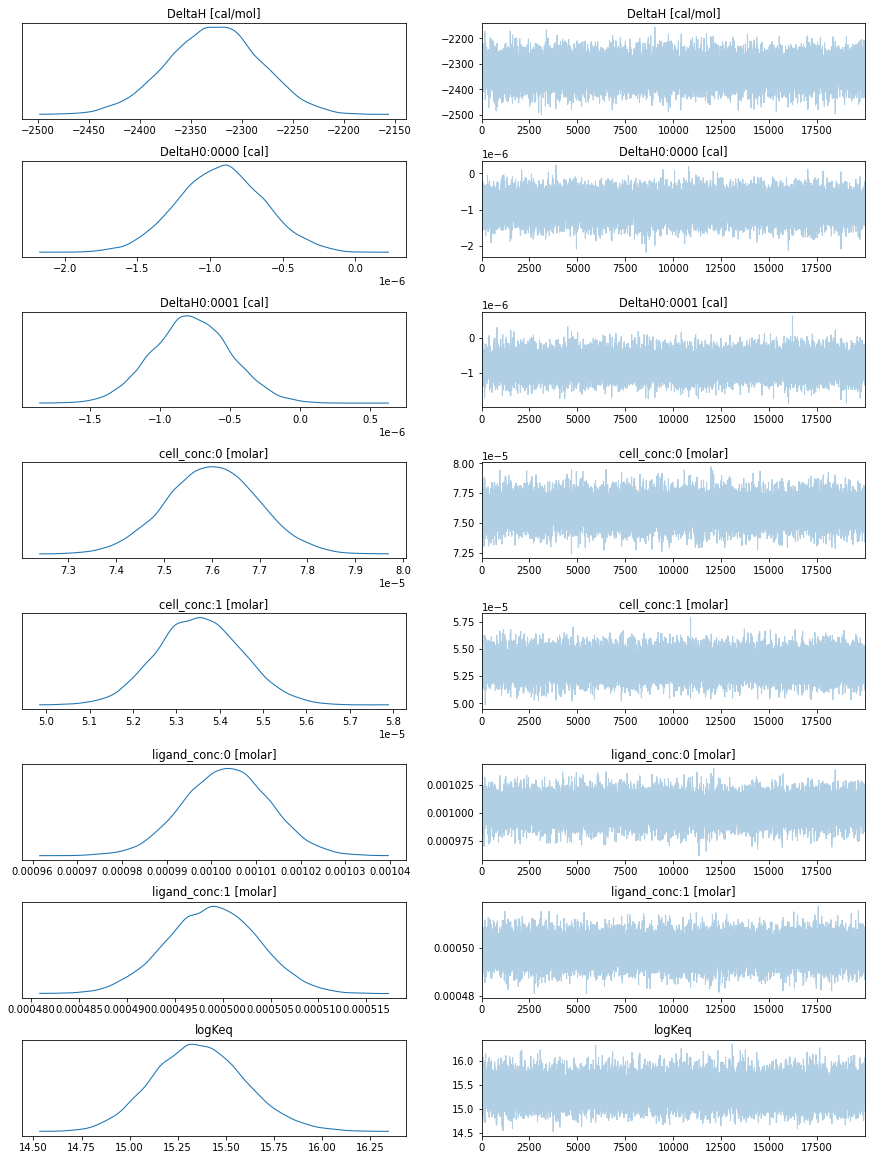

In [15]:
mcmc_wrapper.plot_results(exclude_deterministic=False)

Ain't that pretty neat! The results look pretty good. We can also plot the model's predictions of heat releases vs the actual data to see how well it's doing:

In [16]:
import warnings
with warnings.catch_warnings():
    # we're ignorning warnings because bellini will yell at you that you're not conditioning on measurements
    warnings.simplefilter("ignore") 
    predictions = mcmc_wrapper.predict()

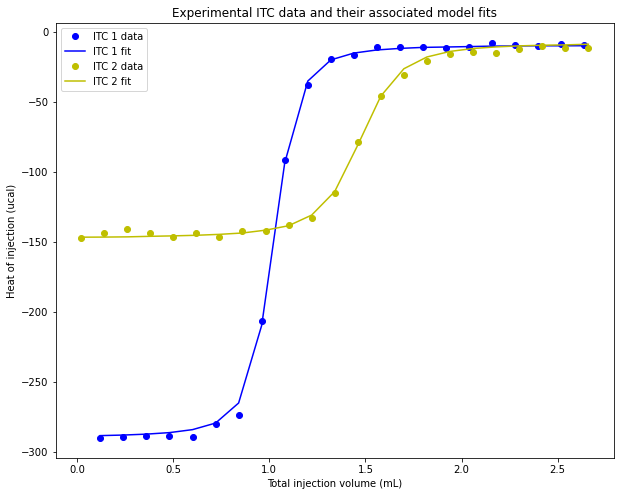

In [17]:
split_idx = len(experiments[0]['injection_heats'])
infer = []
for i, (item, val) in enumerate(obs_data.items()):
    if item.name in predictions.keys():
        infer.append(predictions[item.name].mean())
infer = np.stack(infer)
total_inject_vol_0 = np.array([
    experiments[0]['injection_volumes'][:i].sum() 
    for i in range(len(experiments[0]['injection_volumes']))
])
plt.figure(figsize=(10,8))
plt.plot(total_inject_vol_0[1:] * 10e3, experiments[0]['injection_heats'][1:] * 10e6, 'bo', label="ITC 1 data")
plt.plot(total_inject_vol_0[1:] * 10e3, infer[1:split_idx] * 10e6, 'b-', label="ITC 1 fit")
total_inject_vol_1 = np.array([
    experiments[1]['injection_volumes'][:i].sum() 
    for i in range(len(experiments[1]['injection_volumes']))
])
plt.plot(total_inject_vol_1[1:] * 10e3, experiments[1]['injection_heats'][1:] * 10e6, 'yo', label="ITC 2 data")
plt.plot(total_inject_vol_1[1:] * 10e3, infer[split_idx+1:] * 10e6, 'y-', label="ITC 2 fit")
plt.title("Experimental ITC data and their associated model fits")
plt.xlabel("Total injection volume (mL)")
plt.ylabel("Heat of injection (ucal)")
plt.legend()
plt.show()

That's pretty solid if I do say so myself :o